# Ziffernerkunnung aus Audioaufnahmen
Dieses Notebook behandelt die Klassifizierung bzw. Erkennung von gesprochenen Ziffern mithilfe von Convolutional
Neural Networks (kurz CNN). Der verwendete Datensatz ist frei verfügbar und kann über die Platform Kaggle
heruntergeladen werden. Er enthält insgesamt 3.000 Audioaufnahmen von verschiedenen Sprechern, die jeweils 50 Mal jede
Ziffer eingesprochen haben. Der Code verarbeitet die Audioaufnahmen, leitet Features ab und trainiert ein CNN.

Datensatz verfübar unter: https://www.kaggle.com/jackvial/freespokendigitsdataset

Die Datei _train.csv_ sowie das Verzeichnis _recordings_ sollten im Ordner _Free Spoken Digit Dataset_ im gleichen
Verzeichnis wie dieses Notebook liegen.

## Import der benötigten Pakete

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Data Exploration
Im ersten Schritt, der sogenannten Data Exploration, werden einzelne Audioaufnahmen visualisiert und auf erste sichtbare
Unterschiede untersucht. Aus den vorhandenen 3.000 Aufnahmen wird für verschiedene Ziffern eine zufällige Aufnahme
gewählt und als Waveform sowie Melspectrogram visualisiert.

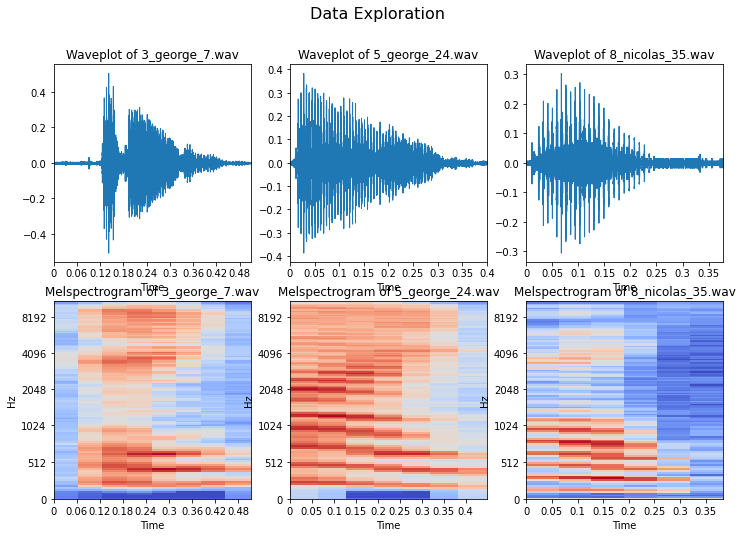

In [4]:
visualize_digits = [3, 5, 8]

description = pd.read_csv('Free Spoken Digit Dataset/train.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(12, 8)
for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('Free Spoken Digit Dataset/recordings', rand_file), sr=None)
    librosa.display.waveplot(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_digits)])
    axs[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

## Feature Engineering
Im nächsten Schritt können aus den Audioaufnahmen Features abgeleitet werden, in diesem Fall ein Melspectrogram. Um
später das neuronale Netz trainieren zu können, müssen alle Features die gleiche Form haben. Da die Aufnahmen jedoch
verschieden lang sind, werden sie durch Time-Stretching auf eine Länge von 1s gebracht. Die Features und Labels der
Aufnahmen werden in Numpy-Arrays abgespeichert, um später einfach damit arbeiten zu können.

In [5]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('Free Spoken Digit Dataset/recordings')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('Free Spoken Digit Dataset/recordings', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
features = np.array(feature_list)
labels = np.array(label_list)

  0%|          | 0/3000 [00:00<?, ?it/s]

Preparing feature dataset and labels.


100%|██████████| 3000/3000 [00:33<00:00, 89.61it/s] 


## Modell Architektur
Nachdem die Daten fertig vorbereitet sind, muss im nächsten Schritt die Architektur bzw. der Aufbau des neuronalen
Netzes festgelegt werden. Mithilfe der Keras Sequential-API können die einzelnen Schichten nacheinander festgelegt
werden.
1. Input Layer: In der ersten Schicht wird lediglich festgelegt, welche Form die eingehenden Daten haben. Dies muss
nicht zwingend als eigene Schicht eingegebenw werden, sondern kann auch bei der nachfolgenden Schicht definiert werden.
2. Conv2D-Layers & MaxPooling: Der nächste Teil ist das Kernstück von CNNs. Innerhalb der Convolutional Layers werden
durch Kernel aus den Daten mögliche relevante Zusammenhänge ermittelt. Die erste Zahl gibt dabei jeweils an, wie viele
Filter erzeugt werden sollen. Die MaxPooling Schicht reduziert die Ausgabe der vorherigen Schichten, indem erneut ein
Kernel über die Daten läuft und aus einem 2 × 2 Feld den größten Wert auswählt.
3. Flatten & Dropout: Das Flatten Layer erzeugt aus einem n-dimensionalen Input einen 1-dimensionalen Tensor/Vektor. Das
Dropout Layer deaktiviert je Epoche zufällig den gegebenen Anteil an Neuronen. Durch diese Methodik kann das sogenannte
Overfitting (Überanpassung an die Trainingsdaten) reduziert werden.
4. Dense Layers: Abschließend beinhaltet das CNN einen Dense Layer mit 64 Neuronen sowie den eigentlichen Klassifikator
(Schicht mit 10 Neuronen, eins für jede Klasse). Durch die Softmax Aktivierungsfunktion werden Werte zwischen 0 und 1
ausgegeben, die als Wahrscheinlichkeit für die einzelnen Klassen gesehen werden können.

Das Netz wird anschließend mit einem Optimizer, Loss-Funktion sowie Metrics kompiliert.

In [15]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(8, 3, padding='same', activation=keras.activations.relu),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(10, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 16, 8)        80        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 16, 16)       1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 8, 16)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

## Trainieren des Modells
Bevor das Modell trainiert werden kann, müssen noch die Labels kodiert sowie die Daten unterteilt werden.
1. Label-Encoding: Wie im letzten Schritt festgelegt, enthält die letzte Schicht des Netzes 10 Neuronen, wodurch die
Ausgabe ein Vektor der Länge 10 ist. Die Labels liegen momentan noch in reinem Textformat vor, was das Netz jedoch
nicht verarbeiten kann. Mithilfe des sogenannten One-Hot_Encodings können die Labels in Vektoren der Länge 10
umgewandelt werden, wobei jeweils an einer Stelle eine 1 steht (daher One-Hot).
2. Unterteilen der Daten: Grundsätzlich wird der Datensatz beim maschinellen Lernen in mindestens zwei Teile unterteilt.
Den größten Anteil machen die Trainingsdaten aus, mit denen das Modell trainiert wird. Der zweite Teil sind die
Testdaten, mit denen das Modell nach dem Training evaluiert werden kann. In diesem Beispiel wird beim Training des
Modells festgelegt, dass von den Trainigsdaten nochmal ein Teil zurückgehalten werden soll. Mit diesen Daten wird schon
während des Trainigs ermittelt, welchen Score das Modell auf neuen Daten erzielen kann.

Nach dem Training können die Ergebnisse der Historie über die einzelnen Epochen hinweg visualisert werden.

Epoch 1/20
23/23 [==============================] - 2s 85ms/step - loss: 22.3219 - accuracy: 0.1181 - val_loss: 2.3026 - val_accuracy: 0.1048

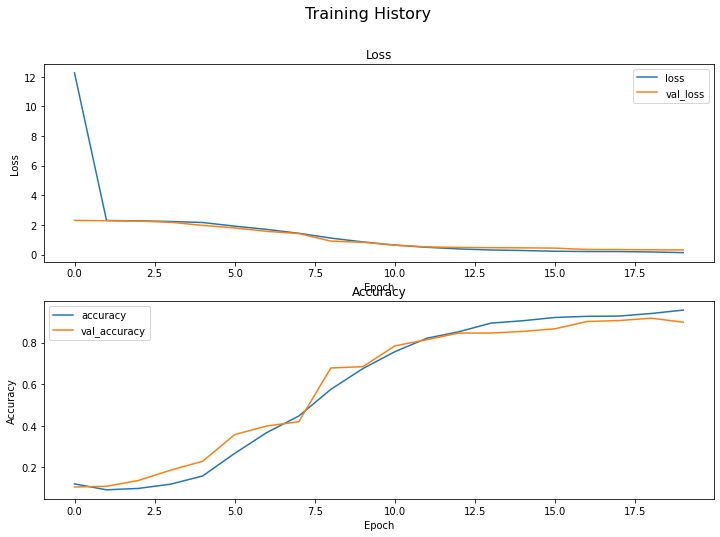

In [16]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 20

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot the training histroy
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

## Evaluieren des Modells
Nach dem Training kann mithilfe der Testmenge, die das Modell bisher nicht gesehen hat, die Genauigkeit auf neuen Daten
ermittelt werden. Diese zeigt an, ob Overfitting oder Underfitting vorliegt, oder das Training ein gutes Ergebnis
erreicht hat.

Die Ergebnisse der Vorhersage können in einer Konfusions-Matrix dargestellt werden. Diese zeigt an, welche Klasse eine
Aufnahme wirklich hat und welche Klasse das Modell vorhergesagt hat. In der Hauptdiagonalen sind dabei die richtigen
Vorhersagen zu finden.

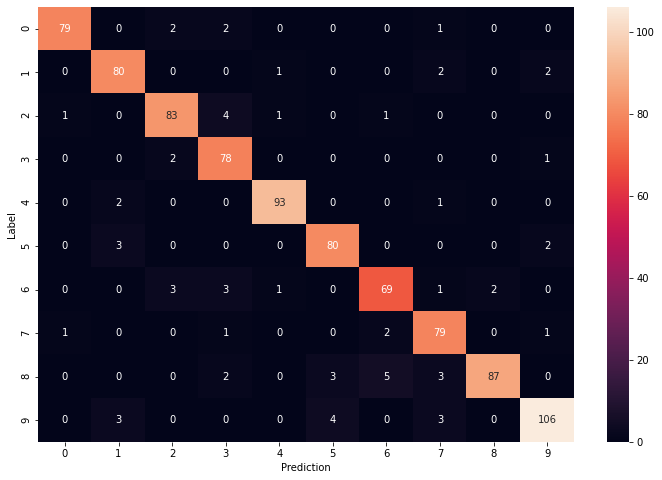

In [17]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()